In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import gdown
import time

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
gdown.download("https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86",
               "fairface-img-margin025-trainval.zip", quiet=False)
gdown.download("https://drive.google.com/uc?id=1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-",
               "fairface-label-train.csv", quiet=False)
gdown.download("https://drive.google.com/uc?id=1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ",
               "fairface-label-val.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
From (redirected): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86&confirm=t&uuid=3d21326f-ac3e-411c-bb18-81fd46661b15
To: /kaggle/working/fairface-img-margin025-trainval.zip
100%|██████████| 578M/578M [00:04<00:00, 140MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-
To: /kaggle/working/fairface-label-train.csv
100%|██████████| 3.54M/3.54M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ
To: /kaggle/working/fairface-label-val.csv
100%|██████████| 416k/416k [00:00<00:00, 104MB/s]


'fairface-label-val.csv'

In [4]:
!unzip -q /kaggle/working//fairface-img-margin025-trainval.zip -d /kaggle/working/fairface

In [7]:
train_csv = '/kaggle/working/fairface-label-train.csv'
test_csv = '/kaggle/working/fairface-label-val.csv'

In [8]:
train_csv = pd.read_csv(train_csv)
test_csv = pd.read_csv(test_csv)
train_csv.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [9]:
train_csv['file'] = '/kaggle/working/fairface/' + train_csv['file']
test_csv['file'] = '/kaggle/working/fairface/' + test_csv['file']
train_csv.file[0]

'/kaggle/working/fairface/train/1.jpg'

In [10]:
val_data,test_data = train_test_split(test_csv,test_size=0.5,random_state=42)
len(val_data), len(test_data)

(5477, 5477)

In [79]:
class GenderAgeDataset(Dataset):
  def __init__(self,df):
    self.df = df
    self.normalize = transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )

    self.augment = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation=0.2),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )


    ])
  def __len__(self):
    return len(self.df)

  def __getitem__(self,ix):
    f = self.df.iloc[ix].squeeze()
    file = f.file
    gen = f.gender == "Female"
    age = f.age
    im = cv2.imread(file)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    return im, age, gen

  def preprocess_image(self,im):
    im = cv2.resize(im,(224,224))
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im.float()/255.)
    return im[None]
  def collate_batch(self,batch):
    imgs,ages,genders = [],[],[]
    for img,age,gender in batch:
      img = self.augment(img)
      imgs.append(img)

      ages.append(float(int(age)/80))
      genders.append(gender)

    ages,genders = [torch.tensor(x).to(device).float() for x in [ages,genders]]
    imgs = torch.stack(imgs).to(device)
    return imgs, ages, genders


In [80]:
train = GenderAgeDataset(train_csv)
val = GenderAgeDataset(val_data)
test = GenderAgeDataset(test_data)

In [81]:
train_loader = DataLoader(train,batch_size=32,shuffle=True,drop_last=True,collate_fn=train.collate_batch)
val_loader = DataLoader(val,batch_size=32,shuffle=True,drop_last=True,collate_fn=val.collate_batch)
test_loader = DataLoader(test,batch_size=32,shuffle=False,drop_last=False,collate_fn=test.collate_batch)

In [82]:
a,b,c = next(iter(train_loader))
a.shape, b.shape, c.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]), torch.Size([32]))

In [94]:
def get_model():
  model = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
  for param in model.parameters():
    param.requires_grad = False

  for param in model.features[24:].parameters():
    param.requires_grad = True

  model.avgpool = nn.Sequential(
      nn.Conv2d(512,512,kernel_size = 3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten()
  )

  class AgeGenderClassifier(nn.Module):
    def __init__(self):
      super(AgeGenderClassifier,self).__init__()
      self.intermediate = nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128,64),
        nn.ReLU(),
    )
      self.age_classifier = nn.Sequential(
        nn.Linear(64,1),
        nn.Sigmoid()
    )
      self.gender_classifier = nn.Sequential(
        nn.Linear(64,1),
        nn.Sigmoid()
    )
    def forward(self,x):
      x = self.intermediate(x)
      age = self.age_classifier(x)
      gender = self.gender_classifier(x)
      return age, gender

  model.classifier = AgeGenderClassifier()
  gender_criterion = nn.BCELoss()
  age_criterion = nn.L1Loss()
  loss_functions = gender_criterion, age_criterion
  optimizer = optim.Adam([
      {'params':model.features[24:].parameters(),'lr':1e-5},
      {'params':model.classifier.parameters(),'lr':1e-4}
  ])
  scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, mode="min", factor=0.5, patience=2, verbose=True
  )
  return model.to(device), loss_functions, optimizer, scheduler


In [95]:
def train_batch(data,model,criterion,optimizer):
  model.train()
  imgs, ages, genders = data
  optimizer.zero_grad()
  pred_age, pred_gender = model(imgs)
  print("Sigmoid gender score:", pred_gender[0][0])
  gender_criterion, age_criterion = criterion
  gender_loss = gender_criterion(pred_gender.squeeze(),genders)
  age_loss = age_criterion(pred_age.squeeze(),ages)
  total_loss = gender_loss * 5.0 + age_loss * 0.5
  total_loss.backward()
  optimizer.step()
  return total_loss


In [96]:
def validate_batch(data,model,criterion):
  model.eval()
  with torch.no_grad():
    imgs, ages, genders = data
    pred_age, pred_gender = model(imgs)
    print("Sigmoid gender score:", pred_gender[0][0])
    gender_criterion, age_criterion = criterion
    gender_loss = gender_criterion(pred_gender.squeeze(),genders)
    age_loss = age_criterion(pred_age.squeeze(),ages)

    total_loss = gender_loss * 5.0 + age_loss * 0.5
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == genders).float().sum()
    age_mae = torch.abs(ages - pred_age).float().sum()
    return total_loss, gender_acc, age_mae


In [97]:
model, criterion, optimizer, scheduler= get_model()

In [98]:
val_gender_accuracies = []
val_age_accuracies = []
train_losses = []
val_losses = []
n_epochs = 5
best_val_loss = 1000
start = time.time()
for epoch in range(n_epochs):
  epoch_train_loss, epoch_val_loss = 0,0
  val_age_mae, val_gender_acc, ctr = 0, 0, 0
  for ix, data in enumerate(train_loader):
    loss = train_batch(data,model, criterion, optimizer)
    epoch_train_loss += loss.item()
  for ix,data in enumerate(val_loader):
    loss, gender_acc, age_mae = validate_batch(data,model,criterion)
    epoch_val_loss += loss.item()
    val_age_mae += age_mae
    val_gender_acc += gender_acc
    ctr += len(data[0])

  val_age_mae /= ctr
  val_gender_acc /= ctr
  epoch_train_loss /= len(train_loader)
  epoch_val_loss /= len(val_loader)
  
  scheduler.step(epoch_val_loss)

  elapsed = time.time() - start

  best_val_loss = min(best_val_loss, epoch_val_loss)
  print(f'{epoch+1} / {n_epochs} - ( {elapsed}  - {(n_epochs - epoch)*(elapsed / (epoch + 1))} )remaining ')
  info = f""" Epoch {epoch + 1:03d}
  \t Train Loss = {epoch_train_loss: .3f}
  \t Validation Loss = {epoch_val_loss: .3f}
  \t Best Test Loss = {best_val_loss: .4f}
  """

  info += f"""
  Gender Accuracy = {val_gender_acc * 100 : .2f}% \t
  Age Accuracy  = {val_age_mae: .2f}% \n

  """
  print(info)
  val_gender_accuracies.append(val_gender_acc.item() if torch.is_tensor(val_gender_acc) else val_gender_acc)
  val_age_accuracies.append(val_age_mae.item() if torch.is_tensor(val_age_mae) else val_age_mae)
  train_losses.append(epoch_train_loss)
  val_losses.append(epoch_val_loss)


Sigmoid gender score: tensor(0.4826, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4881, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4727, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4870, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4638, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4584, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4803, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4571, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4602, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4633, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4561, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor(0.4725, device='cuda:0', grad_fn=<SelectBackward0>)
Sigmoid gender score: tensor

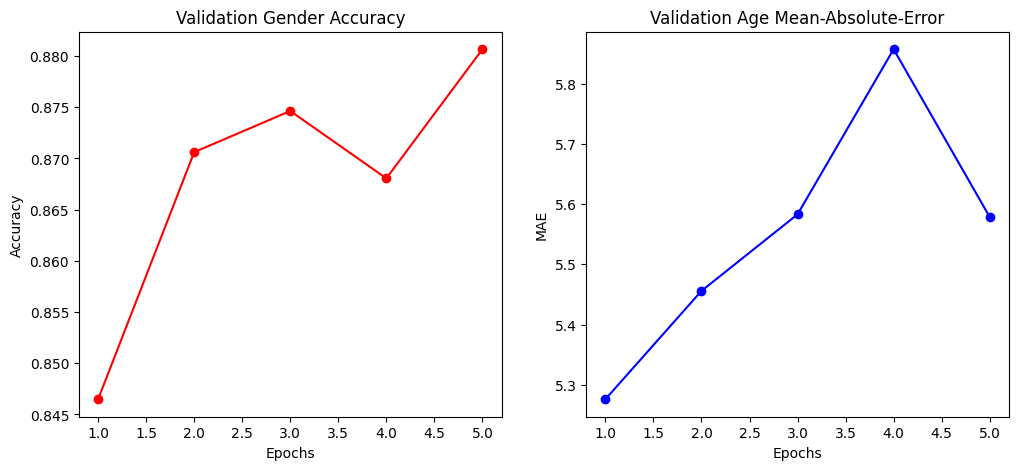

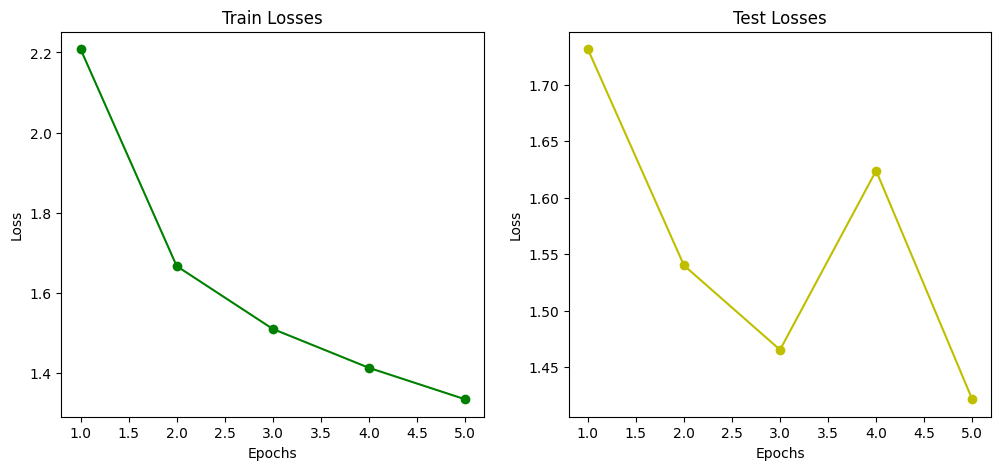

In [99]:
epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, val_gender_accuracies, '-ro')
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Validation Gender Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, val_age_accuracies, 'bo-')
plt.xlabel("Epochs"); plt.ylabel("MAE")
plt.title("Validation Age Mean-Absolute-Error")
plt.show()


epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, '-go')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Train Losses")

plt.subplot(1,2,2)
plt.plot(epochs, val_losses, 'yo-')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Test Losses")
plt.show()


In [117]:
def evalutate_test(model,test_loader,criterion):
  model.eval()
  total_loss, total_gender_acc, total_age_mae, ctr = 0,0,0,0
  with torch.no_grad():
    for imgs,ages,genders in test_loader:
      pred_age, pred_gender = model(imgs)
      gender_criterion, age_criterion = criterion

      gender_loss = gender_criterion(pred_gender.squeeze(),genders)

      age_loss = age_criterion(pred_age.squeeze(),ages)
      total_loss += (gender_loss + age_loss).item()

      pred_gender = (pred_gender > 0.5).squeeze()
      total_gender_acc += (pred_gender == genders).float().sum().item()
      total_age_mae += torch.abs(ages - pred_age.squeeze()).float().sum().item()
      ctr += len(imgs)

    avg_loss = total_loss / len(test_loader)
    avg_gender_acc = total_gender_acc / ctr
    avg_age_mae = total_age_mae / ctr
    return avg_loss, avg_gender_acc, avg_age_mae


In [118]:
test_loss, test_gender_acc, test_age_mae = evalutate_test(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Gender Accuracy: {test_gender_acc*100:.2f}%")
print(f"Test Age MAE: {test_age_mae:.2f}")

Test Loss: 0.397
Test Gender Accuracy: 88.30%
Test Age MAE: 0.13


In [119]:
im = cv2.imread('/kaggle/input/faran-profile-picture/Faran Profile Picture new.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_tensor = test.preprocess_image(im).to(device)

In [120]:
age, gender = model(im_tensor)

In [121]:
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

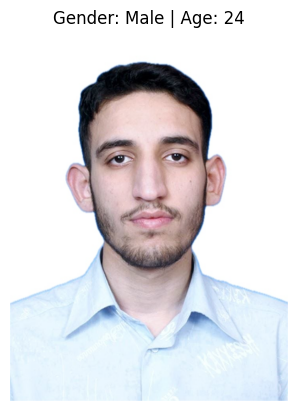

In [122]:
plt.imshow(im)
plt.axis("off")
plt.title(
    f"Gender: {'Female' if pred_gender[0][0] > 0.5 else 'Male'} | Age: {int(pred_age[0][0] * 80)}"
)
plt.show()


In [123]:
torch.save(model.state_dict(), "age_gender_model.pth")

In [125]:

model, criterion, optimizer, scheduler= get_model()
checkpoint = torch.load("age_gender_model.pth",map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

1. 

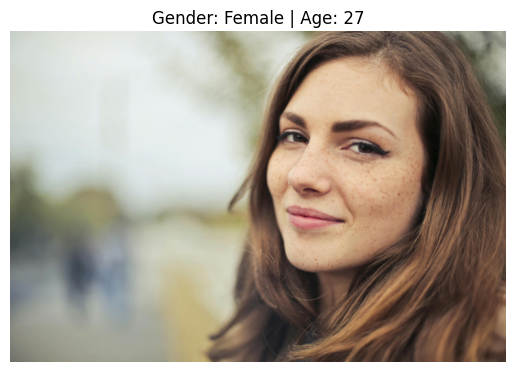

In [135]:
im2 = cv2.imread('/kaggle/input/young-women/pexels-olly-948873.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im2_tensor = test.preprocess_image(im2).to(device)
age, gender = model(im2_tensor)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
plt.imshow(im2)
plt.axis("off")
plt.title(
    f"Gender: {'Female' if pred_gender[0][0] > 0.5 else 'Male'} | Age: {int(pred_age[0][0] * 80)}"
)
plt.show()